In [0]:
from google.colab import drive
drive.mount('/content/drive/')

# Dependencies

In [0]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob
import torchvision.transforms.functional as tf

from osgeo import gdal

In [3]:
!ls 'drive/My Drive/cloudnet'
data_dir = 'drive/My Drive/cloudnet'

cloud  cloud_mask


# Information about a data sample

The following code provides a lot of information about the data sample. But the most important information that we need is the number of bands and which bands bolong to RGB.

In [0]:

#function to provide detailed information about a raster data sample

def raster_info(raster_path):
  
    ds = gdal.Open(raster_path)
    print('File list:', ds.GetFileList())
    print('Width:', ds.RasterXSize)
    print('Height:', ds.RasterYSize)
    print('Coordinate system:', ds.GetProjection())
    
    gt = ds.GetGeoTransform() # captures origin and pixel size
    print('Origin:', (gt[0], gt[3]))
    print('Pixel size:', (gt[1], gt[5]))
    print('Upper Left Corner:', gdal.ApplyGeoTransform(gt,0,0))
    print('Upper Right Corner:', gdal.ApplyGeoTransform(gt,ds.RasterXSize,0))
    print('Lower Left Corner:', gdal.ApplyGeoTransform(gt,0,ds.RasterYSize))
    print('Lower Right Corner:',gdal.ApplyGeoTransform(gt,ds.RasterXSize,ds.RasterYSize))
    print('Center:', gdal.ApplyGeoTransform(gt,ds.RasterXSize/2,ds.RasterYSize/2))
    print('Metadata:', ds.GetMetadata())
    print('Image Structure Metadata:', ds.GetMetadata('IMAGE_STRUCTURE'))
    print('Number of bands:', ds.RasterCount)
    
    band_array_list = []
    for i in range(1, ds.RasterCount+1):
      
      band = ds.GetRasterBand(i) # in GDAL, band are indexed starting at 1!
      interp = band.GetColorInterpretation()
      interp_name = gdal.GetColorInterpretationName(interp)
      (w,h)=band.GetBlockSize()
      print('Band %d, block size %dx%d, color interp %s' % (i,w,h,interp_name))
      ovr_count = band.GetOverviewCount()
      
      # band array list would be used to do further computations on different bands
      band_array = band.ReadAsArray()
      band_array_list.extend([band_array])
      
      for j in range(ovr_count):
        
        ovr_band = band.GetOverview(j) # but overview bands starting at 0
        print('  Overview %d: %dx%d'%(j, ovr_band.XSize, ovr_band.YSize))
    
    #return a list containing the values of all bands as an array
    return band_array_list

# Explore and visualize a raster sample

In [5]:
# path of a sample raster data

raster_path = 'drive/My Drive/cloudnet/cloud/20180516_S2_20m_2240_0.tif'
band_array_list = raster_info(raster_path)

File list: ['drive/My Drive/cloudnet/cloud/20180516_S2_20m_2240_0.tif']
Width: 224
Height: 224
Coordinate system: PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]
Origin: (272762.671, 2658650.0)
Pixel size: (20.0, -20.0)
Upper Left Corner: [272762.671, 2658650.0]
Upper Right Corner: [277242.671, 2658650.0]
Lower Left Corner: [272762.671, 2654170.0]
Lower Right Corner: [277242.671, 2654170.0]
Center: [275002.671, 2656410.0]
Metadata: {'AREA_OR_POI

In [6]:
len(band_array_list)

10

In [7]:
band_array_list

[array([[ 567,  563,  557, ..., 1045,  649,  499],
        [ 556,  554,  554, ...,  714,  493,  504],
        [ 584,  588,  559, ...,  667,  573,  523],
        ...,
        [ 879,  952,  617, ..., 5596, 5367, 6210],
        [ 734,  690,  676, ..., 8668, 7570, 5865],
        [ 764,  685,  816, ..., 9637, 8493, 7544]], dtype=uint16),
 array([[ 460,  464,  470, ..., 1328,  881,  692],
        [ 461,  459,  473, ...,  951,  671,  824],
        [ 486,  483,  457, ...,  912,  718,  803],
        ...,
        [1028, 1158,  815, ..., 6324, 5210, 5195],
        [ 816,  783,  927, ..., 8597, 7543, 5532],
        [ 853,  783,  837, ..., 9464, 8180, 8231]], dtype=uint16),
 array([[ 272,  268,  274, ..., 1488,  777,  410],
        [ 282,  281,  277, ...,  830,  377,  367],
        [ 288,  293,  278, ...,  632,  452,  412],
        ...,
        [ 790,  804,  440, ..., 6854, 6176, 5041],
        [ 599,  557,  608, ..., 8065, 7129, 5799],
        [ 695,  542,  703, ..., 9504, 7768, 7545]], dtype=uint

In [0]:
# function to visualise a sample

def show_images(images, cols = 1):

    n_images = len(images)
    titles = ['Band %d' % i for i in range(1,n_images + 1)]
    plt.figure(figsize=(20,10))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(len(images) / cols + 1, cols, i + 1)
        plt.imshow(image)
        plt.title(title)
    

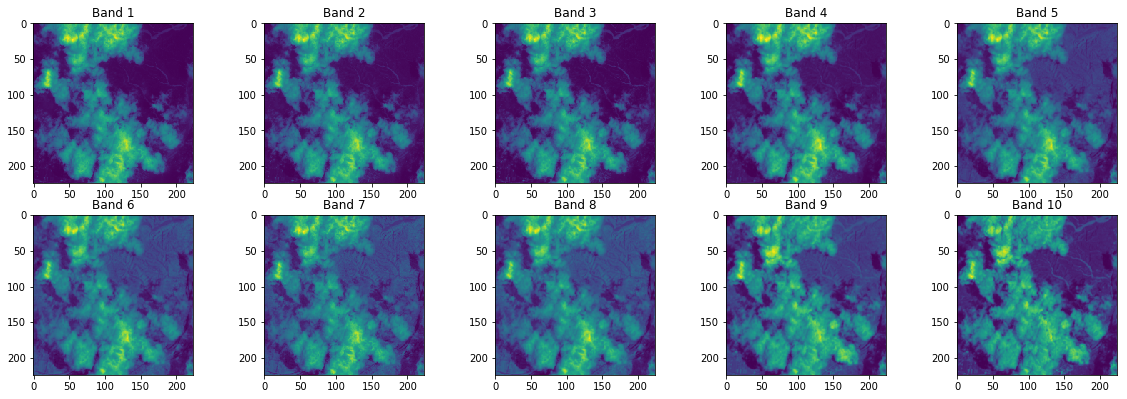

In [9]:
show_images(band_array_list, cols = 5)

###  Visualise the RGB bands

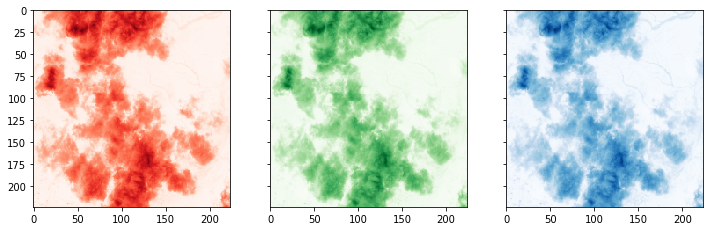

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize = (12,12))

img1 = ax1.imshow(band_array_list[0], cmap = 'Reds')
ax1.axis('on') 

img2 = ax2.imshow(band_array_list[1], cmap = 'Greens')
ax2.axis('on')    

img3 = ax3.imshow(band_array_list[2], cmap = 'Blues')
ax3.axis('on')

plt.show() 

# Explore and visualize cloud mask for the raster sample

In [11]:
# path of the cloud mask

raster_path = 'drive/My Drive/cloudnet/cloud_mask/20180516_S2_20m_2240_0.tif'
mask_array_list = raster_info(raster_path)

File list: ['drive/My Drive/cloudnet/cloud_mask/20180516_S2_20m_2240_0.tif']
Width: 224
Height: 224
Coordinate system: PROJCS["WGS 84 / UTM zone 51N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32651"]]
Origin: (272762.671, 2658650.0)
Pixel size: (20.0, -20.0)
Upper Left Corner: [272762.671, 2658650.0]
Upper Right Corner: [277242.671, 2658650.0]
Lower Left Corner: [272762.671, 2654170.0]
Lower Right Corner: [277242.671, 2654170.0]
Center: [275002.671, 2656410.0]
Metadata: {'AREA_O

In [12]:

len(mask_array_list) 

1

In [13]:
mask_array_list

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)]

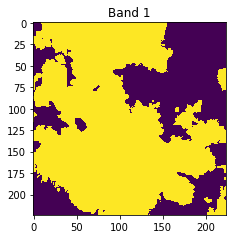

In [14]:
show_images(mask_array_list, cols = 5)

### Visualise RGB bands and cloud mask

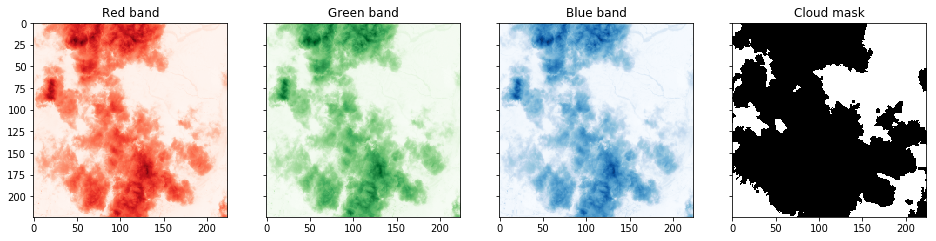

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize = (16,16))

img1 = ax1.imshow(band_array_list[0], cmap = 'Reds')
ax1.set_title('Red band')
ax1.axis('on') 

img2 = ax2.imshow(band_array_list[1], cmap = 'Greens')
ax2.set_title('Green band')
ax2.axis('on')    

img3 = ax3.imshow(band_array_list[2], cmap = 'Blues')
ax3.set_title('Blue band')
ax3.axis('on')

img4 = ax4.imshow(mask_array_list[0], cmap = 'Greys')
ax4.set_title('Cloud mask')
ax4.axis('on')

plt.show()

# Custom dataset class to load data

In [0]:
class CloudDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        

    def __getitem__(self, index):
        
        raster_band_list = raster_info(self.image_paths[index])
        mask_band_list = raster_info(self.mask_paths[index])
        # transform your images here
        #image_tranform = transforms.ToTensor()(image)
        mask_transform = transforms.ToTensor()(mask)


        return mask_transform

    def __len__(self):
        return len(self.image_paths) 

In [17]:
# Define function hyperparameters
image_paths = glob.glob("drive/My Drive/cloudnet/cloud/*.tif")
mask_paths = glob.glob("drive/My Drive/cloudnet/cloud_mask/*.tif")

# Call your function and get a dataloader
cloud_dataset = CloudDataset(image_paths, mask_paths)
print(len(cloud_dataset))

120


torch.Size([1, 224, 224])
1 224 224


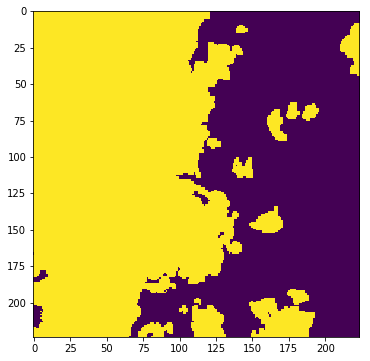

In [18]:
x = cloud_dataset[0]
print(x.size())
layer, height, width = (x.size())
print(layer, height, width)
mask = torch.FloatTensor(1, height, width)
mask = tf.to_pil_image(mask)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize = (6,6))
img1 = ax1.imshow(mask)
ax1.axis('on')        
plt.show()    

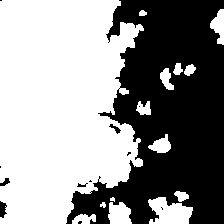

In [19]:
mask

torch.Size([1, 224, 224])


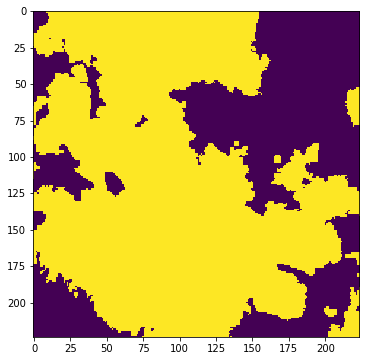

In [20]:
y = Image.open('drive/My Drive/cloudnet/cloud_mask/20180516_S2_20m_2240_0.tif')
y = transforms.ToTensor()(y)
print(y.shape)
layer, height, width = (y.size())
mask = torch.FloatTensor(1, height, width)
mask = tf.to_pil_image(mask)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize = (6,6))
img1 = ax1.imshow(mask)
ax1.axis('on')        
plt.show() 

In [21]:
y

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]]])

In [22]:
y.dtype

torch.float32

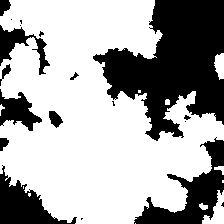

In [23]:
mask